In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'
from GRB_population import GRBPopulation
import physics as ph
import numpy as np
import io_grb_pop as io
import miscellaneous as msc
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import plotting_functions as pf
import json
plt.style.use('presentation')
paths_to_dir, paths_to_files = io.generate_paths()
config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
config['output_dir'] = 'debugger'
paths_to_dir['output'] = paths_to_dir['output']/config['output_dir']

In [4]:
config['Nb_GRBs'] = '1e6'
config['samples'] = ['Stern', 'EpGBM', 'eBAT6','BATSE_5B_sample', 'GBM_sample', 'Swift_bright']
print(json.dumps(config, indent=4))
print(json.dumps(params, indent=4))

{
    "output_dir": "debugger",
    "Nb_GRBs": "1e6",
    "samples": [
        "Stern",
        "EpGBM",
        "eBAT6",
        "BATSE_5B_sample",
        "GBM_sample",
        "Swift_bright"
    ],
    "constraints": [
        "Stern",
        "EpGBM",
        "eBAT6"
    ],
    "save_all_GRBs": false,
    "likelihood": {
        "epsilon": 0.001
    }
}
{
    "luminosity_function": {
        "model": "ES",
        "logLmin": 49.6989700043,
        "logLmax": 53.0,
        "logLbreak": 52.56,
        "slope": 1.41,
        "k_evol": 1.0
    },
    "redshift_distribution": {
        "model": "BExp",
        "zmax": 20,
        "zm": 2.18,
        "a": 0.94,
        "b": -0.52,
        "zeta": null
    },
    "spectral_shape": {
        "model": "GBM_Band",
        "alpha": 0.6,
        "beta": 2.5
    },
    "peak_energy_distribution": {
        "model": "LN",
        "Ep0": 690,
        "sigmaEp": 0.45,
        "alpha_amati": 0.3
    },
    "t90obs_distribution": {
        "mu": 1.4

In [5]:
cosmo = init_cosmology(paths_to_dir['cosmo'])
ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                            ECLAIRs_config=instruments['ECLAIRs'])
samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

Nb_GRBs = int(float(config['Nb_GRBs']))

incl_samples, incl_instruments, incl_constraints = msc.create_config(config=config,
                                                       samples=samples,
                                                       instruments=instruments,
                                                       obs_constraints=obs_constraints)


|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+06                              |
|                     Output directory = debugger                              |
|                                  Properties                                  |
 prop          |     median    |     stdev     |      min      |      max      
--------------------------------------------------------------------------------
 z             |   2.3630e+00  |   1.3950e+00  |   1.8000e-02  |   1.9838e+01   
 L             |   7.5446e+50  |   2.2894e+52  |   5.4899e+49  |   2.7561e+54   
 Ep            |   6.8850e+02  |   1.6313e+03  |   3.7545e+00  |   9.5186e+04   
 alpha         |   6.5002e-01  |   3.3089e-01  |  -7.0564e-01  |   1.7264e+00   
 beta          |   2.4989e+00  |   4.0915e-01  |   2.0017e+00  |   4.0481e+00   
 ktild         |   1.0060e+00  |   7.5721e-01  |   2.1920e-03  |   8.8807e+00   
 D_L           |   1.9321e+0

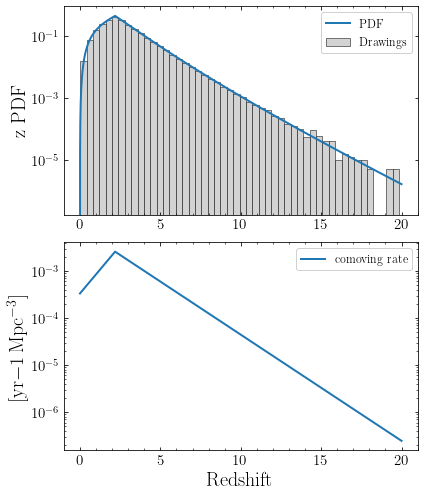

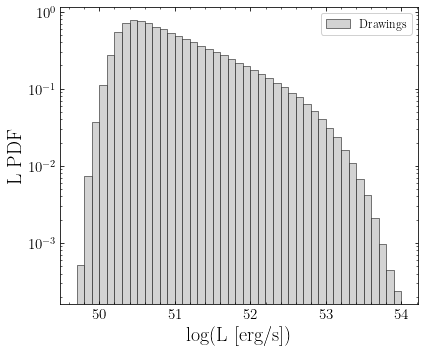

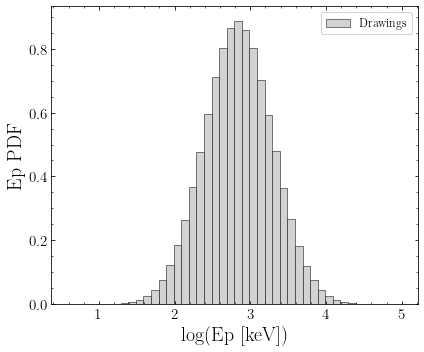

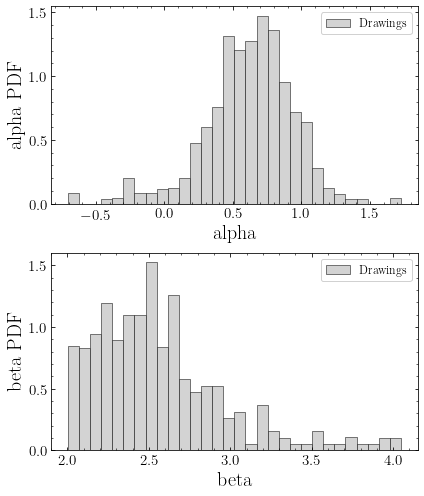

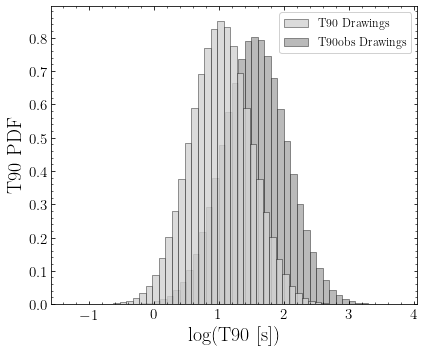

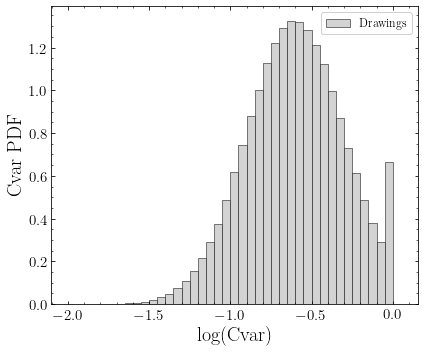

In [6]:
np.random.seed(0)
GRB_population = GRBPopulation(Nb_GRBs, output_dir=paths_to_dir['output'])
GRB_prop = GRB_population.draw_GRB_properties(cosmo=cosmo, params=params, run_mode='debug')

ph.calc_peak_photon_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
ph.calc_peak_energy_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
ph.calc_photon_fluence(GRB_prop, incl_instruments)
ph.calc_energy_fluence(GRB_prop, incl_instruments)
ph.calc_det_prob(GRB_prop, incl_samples, **ECLAIRs_prop)

df = pd.DataFrame(GRB_prop)

In [7]:
Stern_cond = df['pdet_Stern'] == 1
BATSE_5B_cond = df['pdet_BATSE_5B_sample'] == 1
eBAT6_cond = df['pdet_eBAT6'] == 1
EpGBM_cond = df['pdet_EpGBM'] == 1
GBM_cond = df['pdet_GBM_sample'] == 1
Swift_cond = df['pdet_Swift_bright'] == 1
# SHOALS_cond = df['pdet_SHOALS'] == 1

df_Stern = df[Stern_cond]
df_eBAT6 = df[eBAT6_cond]
df_BATSE_5B = df[BATSE_5B_cond]
df_EpGBM = df[EpGBM_cond]
df_GBM = df[GBM_cond]
df_Swift = df[Swift_cond]
# df_SHOALS = df[SHOALS_cond]

In [8]:

def plot_pht_pflx_flnc_plane(df, sample, fname, superfluous_cols,
                             obs_sname,
                             obs_pflx_key,
                             obs_flnc_key,
                             mod_pflx_key=None,
                             mod_flnc_key=None,
                             t90_key='t90',
                             bins_pflx=None,
                             bins_flnc=None,
                             long=False,
                             pflx_min=None,
                             color='C0',
                             verbose=False):
    """
        Convenience function to plot the photon peak flux - photon fluence plane for a given sample
    """
    
    
    # GRB pop model
    instr = incl_samples[sample]['instrument']
    Emin = incl_instruments[instr]['Emin']
    Emax = incl_instruments[instr]['Emax']
    cond = df[f'pdet_{sample}'] == 1

    # Observations
    df_obs = pd.read_csv(fname, sep='|', header=2, low_memory=False)
    for col in superfluous_cols:
       del df_obs[col]
    df_obs.rename(columns=lambda x:x.strip(), inplace=True)
    if verbose:
        print(df_obs.columns)
    for key in [obs_pflx_key, obs_flnc_key, t90_key]:
        df_obs[key] = pd.to_numeric(df_obs[key], errors='coerce')
    if long and pflx_min is not None:
        long_cut = (df_obs[t90_key] >= 2)
        pflx_cut = (df_obs[obs_pflx_key] >= pflx_min)
        cuts = long_cut & pflx_cut
    elif pflx_min is not None:
        pflx_cut = (df_obs[obs_pflx_key] >= pflx_min)
        cuts = pflx_cut
    else:
        cuts = np.isfinite(df_obs[obs_pflx_key]) & np.isfinite(df_obs[obs_flnc_key])
    df_obs = df_obs[cuts].dropna()
    
    if bins_pflx is None:
        bins_pflx = np.linspace(np.log10(pflx_min), np.log10(300.), 50)
    if bins_flnc is None:
        bins_flnc = np.linspace(np.log10(0.1), np.log10(3000.), 50)

    if mod_pflx_key is None:
        mod_pflx_key = f'pht_pflx_{instr}'
    if mod_flnc_key is None:
        mod_flnc_key = f'pht_flnc_{instr}'
    # Plot Model
    fig, axes = pf.cool_hist2d(x=np.log10(df[cond][mod_pflx_key].to_numpy()), 
                               y=np.log10(df[cond][mod_flnc_key].to_numpy()), cb=False, 
                               mode='hist2d', 
                               top_kdeplot_kwargs={'color': 'k', 'label': 'Model'},
                               left_kdeplot_kwargs={'color': 'k', 'label': None},
                               top_hist_kwargs={'color': 'gray','alpha':0.3,'bins':bins_pflx,'edgecolor':'k','linewidth':0.5},
                               left_hist_kwargs={'color': 'gray','alpha':0.3,'bins':bins_flnc,'edgecolor':'k','linewidth':0.5})
   

    # Plot observations
    pf.cool_hist2d(x=np.log10(df_obs[obs_pflx_key].to_numpy()), 
                   y=np.log10(df_obs[obs_flnc_key].to_numpy()),
                   fig=fig, cb=False, 
                   mode='hist2d', 
                   top_kdeplot_kwargs={'color': color, 'label': f'{obs_sname} catalog'},
                   left_kdeplot_kwargs={'color': color, 'label': None},
                   top_hist_kwargs={'color': color,'edgecolor':'k','linewidth':0.5,'bins':bins_pflx, 'alpha':0.3},
                   left_hist_kwargs={'color': color,'edgecolor':'k','linewidth':0.5,'bins':bins_flnc, 'alpha':0.3},
                   hist2d_kwargs={'plot_density':False,
                                  'plot_datapoints':False,
                                  'no_fill_contours':True,
                                  'contour_kwargs':{'colors':color}})


    axes['center'].set_xlabel(f'log peak flux [{Emin:.0f} keV - {Emax:.0f} keV]')
    axes['left'].set_ylabel(f'log fluence [{Emin:.0f} keV - {Emax:.0f} keV]')
    axes['left'].invert_xaxis()

    return fig, axes



/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


(<Figure size 648x504 with 3 Axes>,
 {'center': <matplotlib.axes._axes.Axes at 0x7fd94961c5c0>,
  'left': <matplotlib.axes._axes.Axes at 0x7fd938fa4438>,
  'top': <matplotlib.axes._axes.Axes at 0x7fd938f99080>})

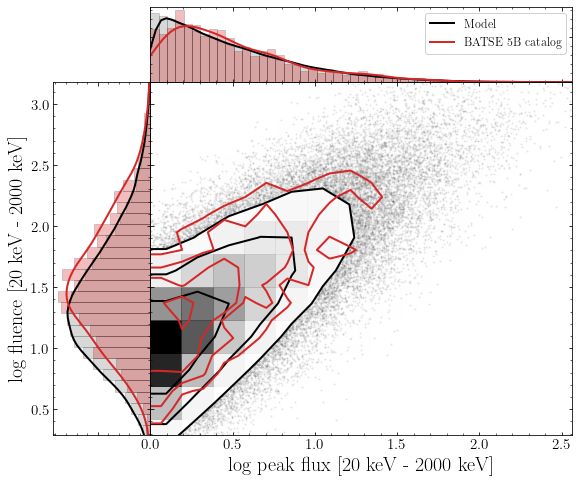

In [9]:
Goldstein_file = Path('../catalogs/BATSE_cat/BATSE_cat_complete_5B.txt')
sfl_cols = ['#%', 'Unnamed: 186']
plot_pht_pflx_flnc_plane(df=df, sample='BATSE_5B_sample',
                         fname=Goldstein_file,
                         superfluous_cols=sfl_cols,
                         obs_sname='BATSE 5B',
                         obs_pflx_key='pflx_band_phtflux',
                         obs_flnc_key='flnc_band_phtflnc',
                         long=True,
                         pflx_min=1.0,
                         color='C3')

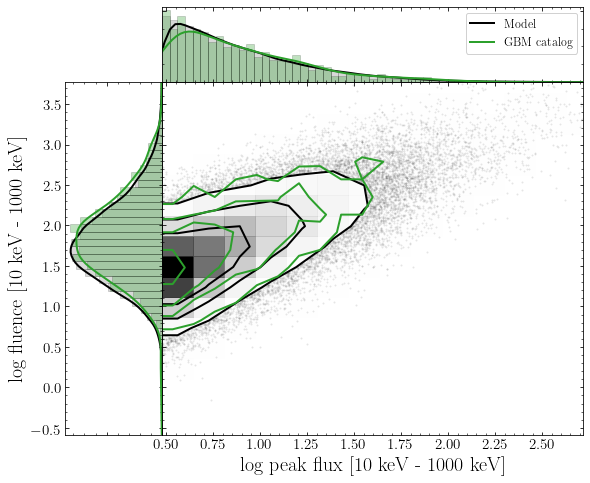

In [10]:
GBM_file = Path('../catalogs/GBM_cat/GBM_cat_complete2.txt')
sfl_cols = ['#%', 'Unnamed: 307']
plot_pht_pflx_flnc_plane(df=df, sample='GBM_sample',
                         fname=GBM_file,
                         superfluous_cols=sfl_cols,
                         obs_sname='GBM',
                         pflx_min=3,
                         obs_pflx_key='pflx_band_phtflux',
                         obs_flnc_key='flnc_band_phtflnc',
                         long=True,
                         color='C1')
ax = plt.gcf().axes[0]
# ax.axhline(np.log10(0.9))
# ax.axvline(np.log10(2.5))

(<Figure size 648x504 with 3 Axes>,
 {'center': <matplotlib.axes._axes.Axes at 0x7fd95ce5c400>,
  'left': <matplotlib.axes._axes.Axes at 0x7fd96ae11ac8>,
  'top': <matplotlib.axes._axes.Axes at 0x7fd92ef7d710>})

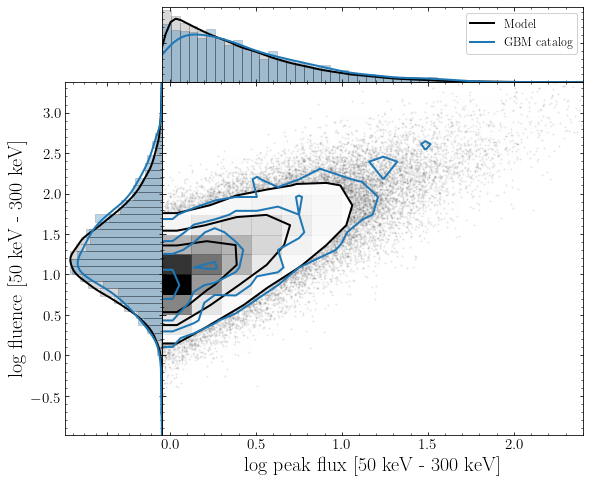

In [11]:
GBM_file = Path('../catalogs/GBM_cat/GBM_cat_complete2.txt')
sfl_cols = ['#%', 'Unnamed: 307']
plot_pht_pflx_flnc_plane(df=df, sample='EpGBM',
                         fname=GBM_file,
                         superfluous_cols=sfl_cols,
                         obs_sname='GBM',
                         pflx_min=0.9,
                         obs_pflx_key='pflx_band_phtfluxb',
                         obs_flnc_key='flnc_band_phtflncb',
                         long=True,
                         color='C2')

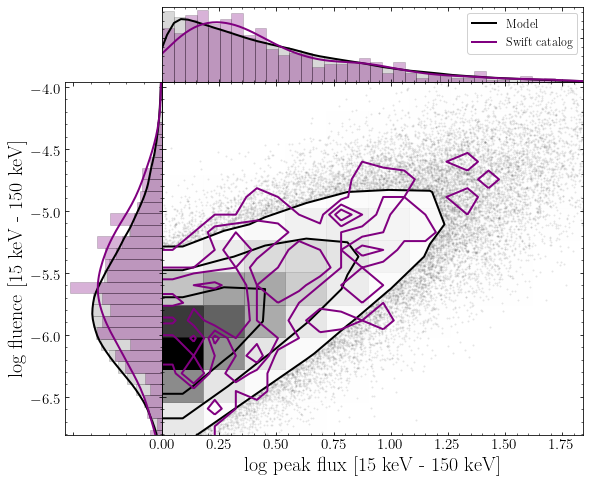

In [12]:
Swift_file = Path('../catalogs/Swift_cat/Swift_cat_complete.txt')
sfl_cols = ['#%', 'Unnamed: 179']
fig, axes = plot_pht_pflx_flnc_plane(df=df, sample='Swift_bright',
                         fname=Swift_file,
                         superfluous_cols=sfl_cols,
                         obs_sname='Swift',
                         pflx_min=1.0,
                         obs_pflx_key='bat_peakfluxp',
                         obs_flnc_key='bat_fluence',
                         mod_flnc_key='erg_flnc_BAT',
                         mod_pflx_key='pht_pflx_BAT',
                         bins_flnc=np.linspace(-7.5,-3, 50),
                         t90_key='bat_t90',
                         long=True,
                         color='purple')


Sample size :1136


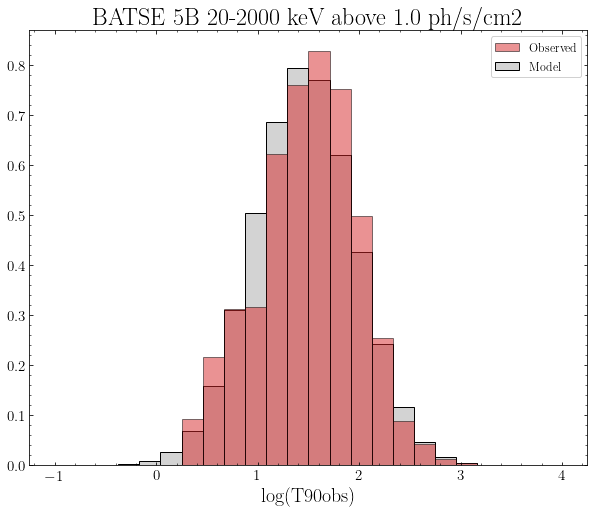

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
bins = np.linspace(-1,4,25)
pf.plot_obs_property('../catalogs/BATSE_cat/BATSE_cat_complete_5B.txt',
                  key='t90',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtflux', 'lim_min':1.0, 'errors':'coerce'}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Observed', alpha=0.5,
                  color='C3', errors='coerce')
ax.set_title('BATSE 5B 20-2000 keV above 1.0 ph/s/cm2')
cond = df['pht_pflx_BATSE_5B'] >= 1.0
ax.hist(np.log10(df[cond]['t90obs']), bins=bins, density=True, label='Model', color='lightgray', zorder=0)
ax.legend()
ax.set_xlabel('log(T90obs)')
plt.show()

Sample size :1313


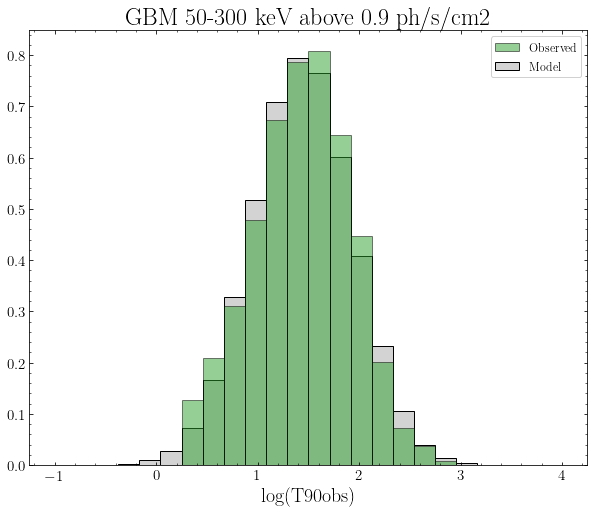

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
bins = np.linspace(-1,4,25)
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='t90',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtfluxb', 'lim_min':0.9, 'errors':'coerce'}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Observed', alpha=0.5,
                  color='C2', errors='coerce')
ax.set_title('GBM 50-300 keV above 0.9 ph/s/cm2')
cond = df['pdet_EpGBM'] == 1
ax.hist(np.log10(df[cond]['t90obs']), bins=bins, density=True, label='Model', color='lightgray', zorder=0)
ax.legend()
ax.set_xlabel('log(T90obs)')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
bins = np.linspace(-1,4,25)
pf.plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='t90',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'pflx_band_phtflux', 'lim_min':3.0, 'errors':'coerce'}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Observed', alpha=0.5,
                  color='C0', errors='coerce')
ax.set_title('GBM 10-1000 keV above 3.0 ph/s/cm2')
cond = df['pht_pflx_GBM'] >= 3.0
ax.hist(np.log10(df[cond]['t90obs']), bins=bins, density=True, label='Model', color='lightgray', zorder=0)
ax.legend()
ax.set_xlabel('log(T90obs)')
plt.show()

Sample size :170


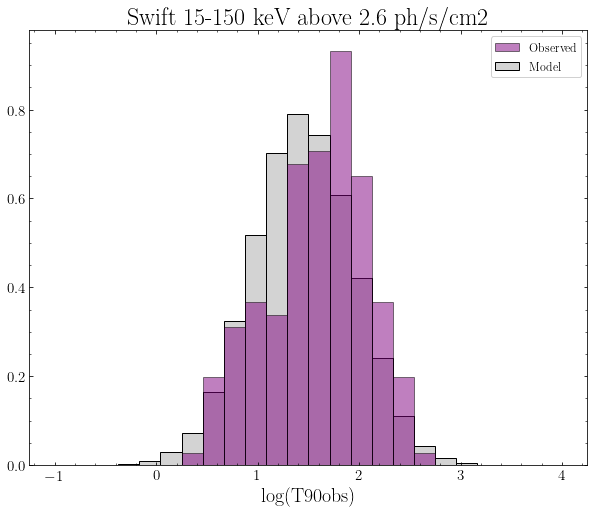

In [45]:
fig, ax = plt.subplots(figsize=(10,8))
bins = np.linspace(-1,4,25)
pf.plot_obs_property('../catalogs/Swift_cat/Swift_cat_complete.txt',
                  key='bat_t90',
                  func=[msc.filter_df, msc.filter_df],
                  func_args=[{'filtering_key':'bat_t90', 'lim_min':2, 'errors':'coerce'},
                             {'filtering_key':'bat_peakfluxp', 'lim_min':2.6, 'errors':'coerce'}],
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Observed', alpha=0.5,
                  color='purple', errors='coerce')
ax.set_title('Swift 15-150 keV above 2.6 ph/s/cm2')
cond = df['pht_pflx_BAT'] >= 2.6
ax.hist(np.log10(df[cond]['t90obs']), bins=bins, density=True, label='Model', color='lightgray', zorder=0)
ax.legend()
ax.set_xlabel('log(T90obs)')
plt.show()